In [1]:
import pickle 
import torch
import torch.nn as nn
import numpy as np
import sys
import random
import optuna
from data import load_mmrf

In [6]:
%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns

## alternate font/graph format
plt.rcParams['ps.useafm'] = True
plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['text.usetex'] = True
plt.rc('font', weight='heavy')
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large')
plt.rc('axes', labelsize='x-large')

/data/ml2/software/anaconda3/envs/disease_prog/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Load in data

In [3]:
fold = 2
data_dir = '/afs/csail.mit.edu/u/z/zeshanmh/research/longlearn/data/ml_mmrf/ml_mmrf/output/cleaned_mm_fold_2mos_trt_resp_ind_seed0.pkl'
ddata = load_mmrf(fold_span = [fold], \
                              digitize_K = 0, \
                              digitize_method = 'uniform', \
                              data_dir=data_dir, \
                              restrict_markers=['serum_m_protein', 'syn_marker'], \
                              add_syn_marker=True, \
                              window='first_second', \
                              data_aug=False, \
                              ablation=False, \
                              feats=[])


loading from: /afs/csail.mit.edu/u/z/zeshanmh/research/longlearn/data/ml_mmrf/ml_mmrf/output/cleaned_mm_fold_2mos_trt_resp_ind_seed0.pkl
adding synthetic marker in fold 2, set train...
new shape of X: (212, 36, 17)
new shape of M: (212, 36, 17)
adding synthetic marker in fold 2, set valid...
new shape of X: (71, 36, 17)
new shape of M: (71, 36, 17)
adding synthetic marker in fold 2, set test...
new shape of X: (96, 36, 17)
new shape of M: (96, 36, 17)
restricting longitudinal markers in fold 2, set train...
new shape of X: (212, 36, 2)
new shape of M: (212, 36, 2)
restricting longitudinal markers in fold 2, set valid...
new shape of X: (71, 36, 2)
new shape of M: (71, 36, 2)
restricting longitudinal markers in fold 2, set test...
new shape of X: (96, 36, 2)
new shape of M: (96, 36, 2)


In [4]:
Xtrain = ddata[fold]['train']['x']
Btrain = ddata[fold]['train']['b']
Ytrain = ddata[fold]['train']['ys_seq']
Atrain = ddata[fold]['train']['a']
Mtrain = ddata[fold]['train']['m']
CEtrain = ddata[fold]['train']['ce']
pids_train= ddata[fold]['train']['pids']
print(Xtrain.shape)
print(Btrain.shape)
print(ddata[fold]['train']['feature_names_x'])
print(ddata[fold]['train']['feature_names'])
print(ddata[fold]['train'].keys())

(212, 36, 2)
(212, 16)
['serum_m_protein' 'syn_marker']
Index(['iss', 'age', 'gender', 'ecog', 'serum_beta2_microglobulin', 'PC1',
       'PC2', 'PC3', 'PC4', 'PC5', 'heavy_chain', 'igg_type', 'iga_type',
       'igm_type', 'kappa_type', 'lambda_type'],
      dtype='object')
dict_keys(['pids', 'x', 'm', 'feature_names_x', 'ys_seq', 'ce', 'feature_names_y', 'b', 'feature_names', 'a', 'm_a', 'feature_names_a'])


## Basic visualization

No handles with labels found to put in legend.


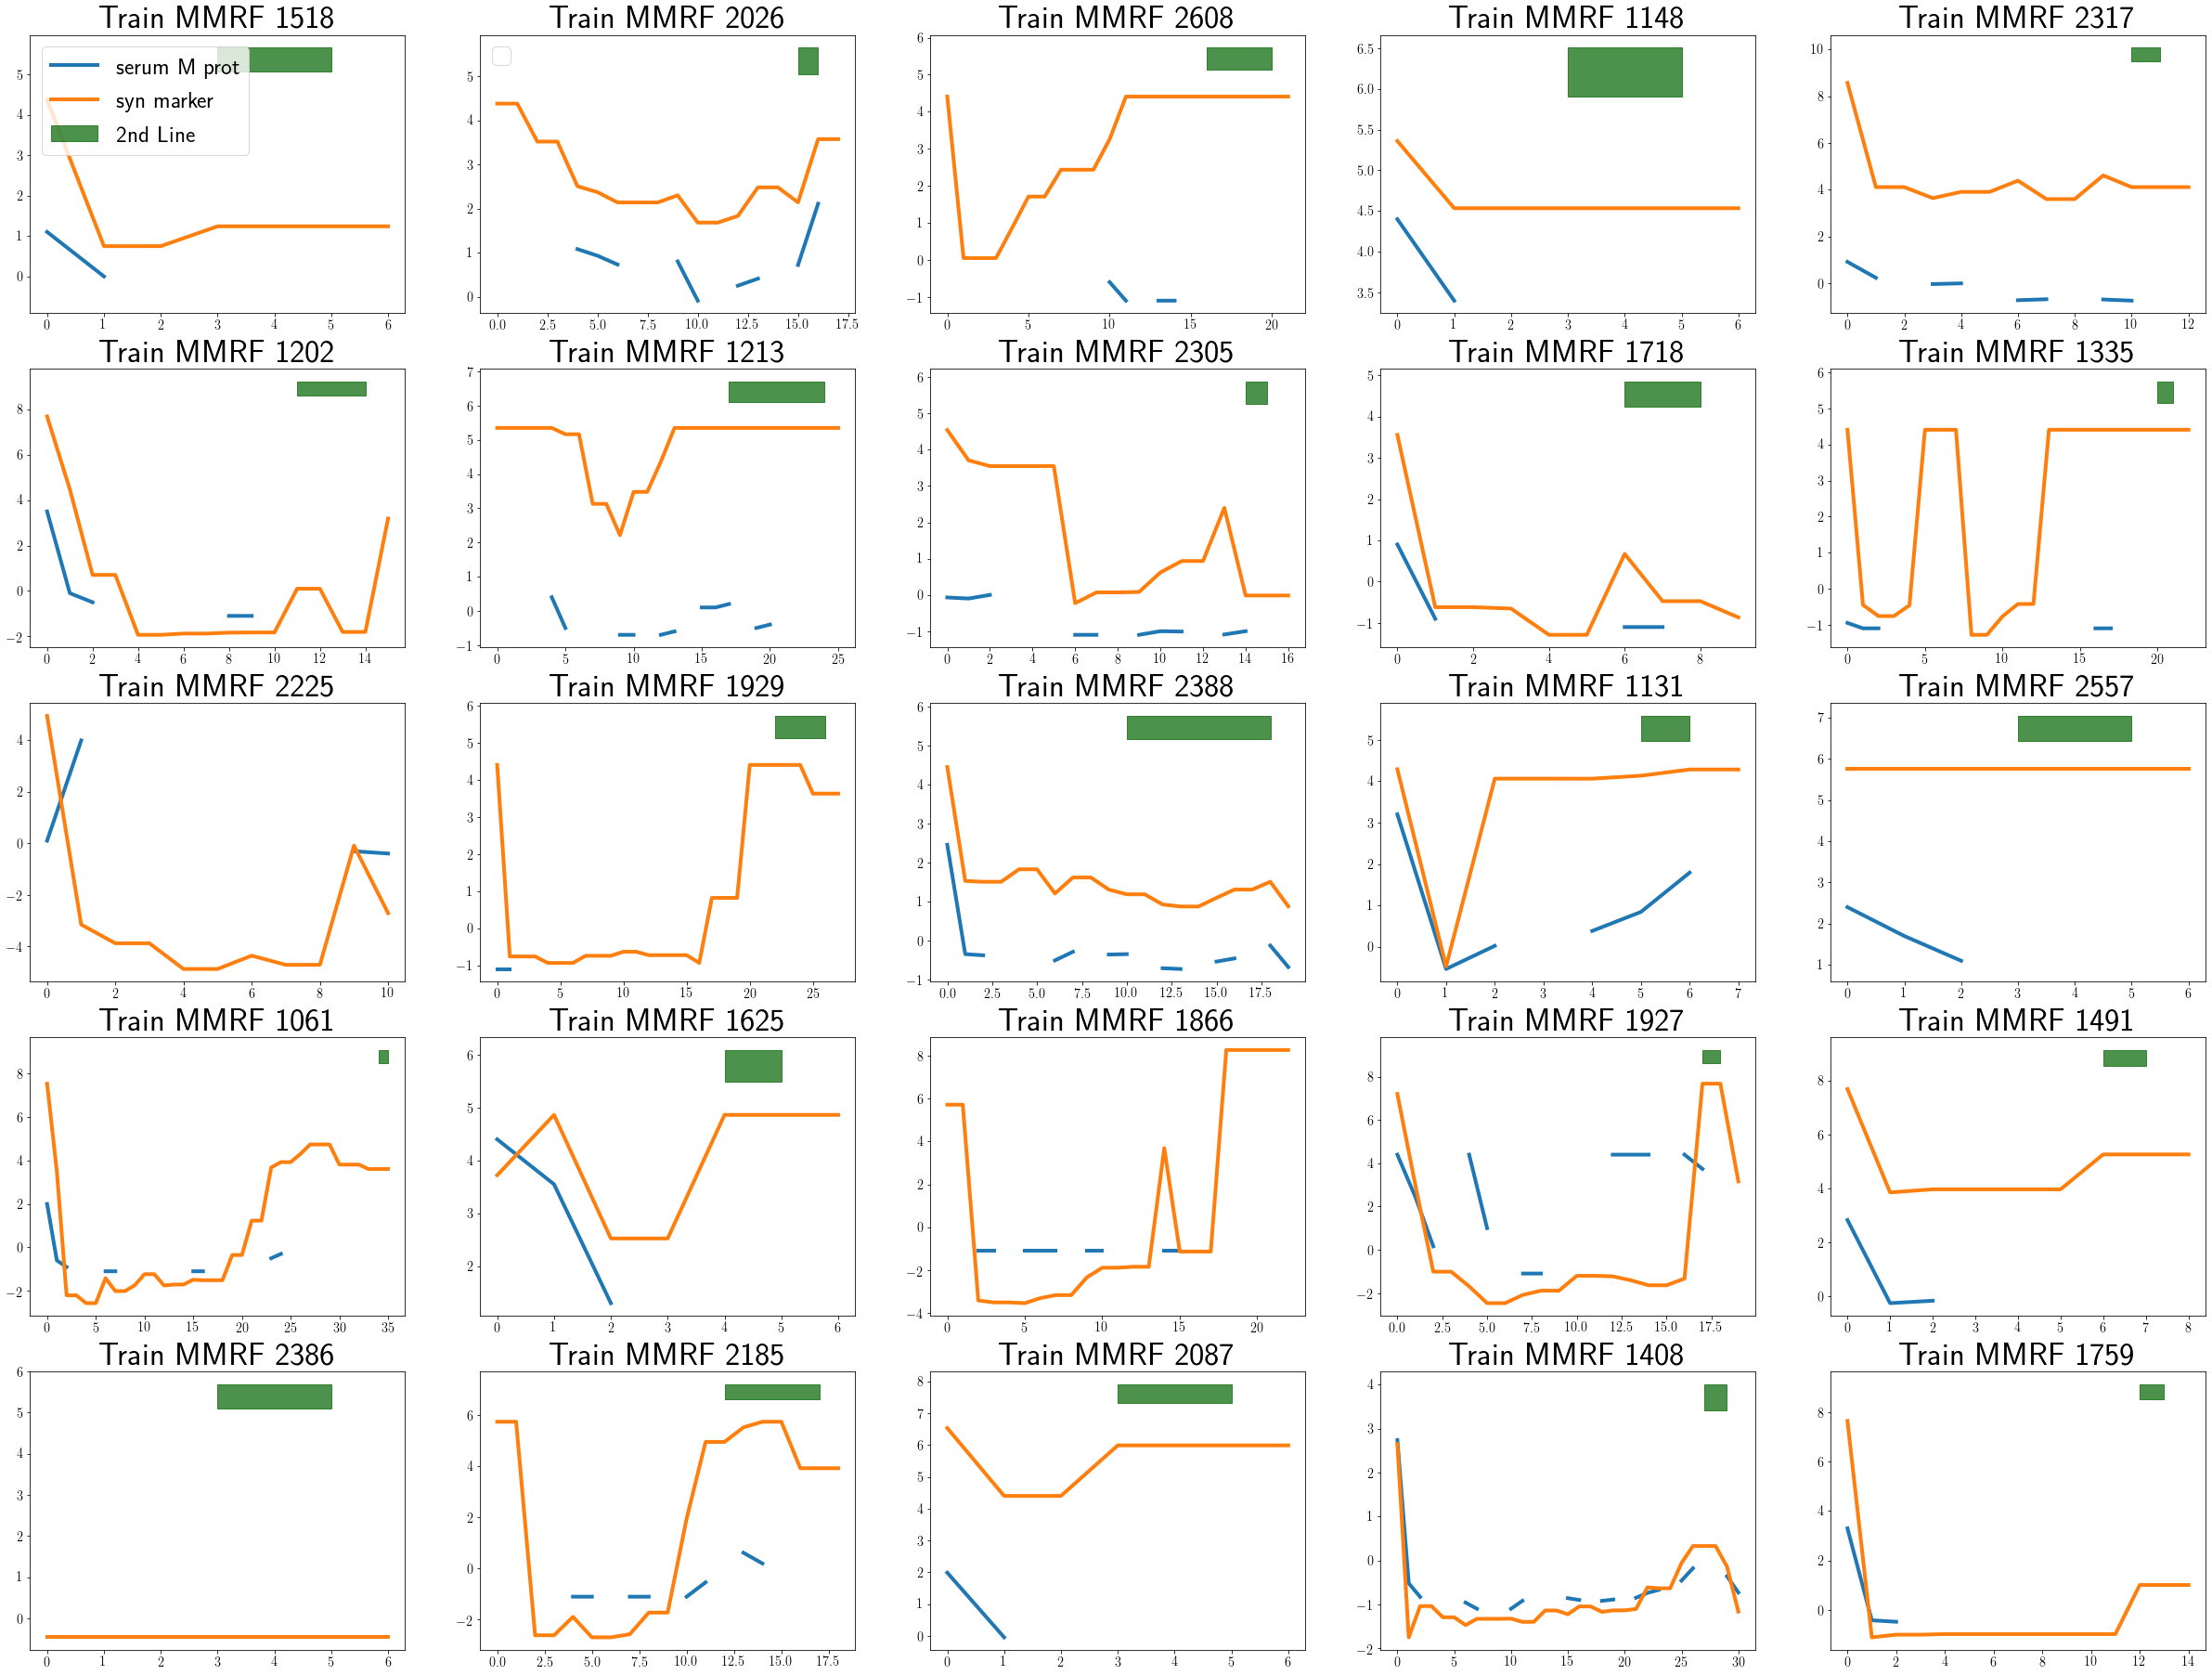

In [8]:
midx = 0; smidx = 1
fig, axlist = plt.subplots(5,5,figsize=(42,32))
ax         = axlist.ravel()
for i,idx in enumerate(range(Xtrain.shape[0])[:25]): 
    second_line = Atrain[idx,:,-2]
    sline_ts  = np.where(second_line == 1.)[0]
    if len(sline_ts) != 0: 
        sline_ts  = np.concatenate((sline_ts,[sline_ts[-1]+1]))
    orig_example = Xtrain[idx]
    orig_example[np.where(Mtrain[idx] == 0.)] = np.nan
    if i == 0: 
        ax[i].plot(np.arange(orig_example.shape[0]), orig_example[:,midx], linewidth=4, label='serum M prot')
        ax[i].plot(np.arange(orig_example.shape[0]), orig_example[:,smidx], linewidth=4, label='syn marker')
        ymax = ax[i].get_ylim()[1]+0.05
        ys = np.array([ymax for x in range(len(sline_ts))])
        ax[i].fill_between(sline_ts, ys+0.4,ys+1., color='darkgreen', alpha=0.7, label='2nd Line')
    else: 
        ax[i].plot(np.arange(orig_example.shape[0]), orig_example[:,midx], linewidth=4)
        ax[i].plot(np.arange(orig_example.shape[0]), orig_example[:,smidx], linewidth=4)
        ymax = ax[i].get_ylim()[1]+0.05
        ys = np.array([ymax for x in range(len(sline_ts))])
        ax[i].fill_between(sline_ts, ys+0.4,ys+1., color='darkgreen', alpha=0.7)
    ax[i].set_title(f'Train MMRF {ddata[fold]["train"]["pids"][idx].split("_")[1]}', fontsize=35)
    if i == 0 or i == 1: 
        ax[i].legend(fontsize=25, loc='upper left')
# fig.suptitle(f'Feature Set over Time for Patient Cluster {cnum}', fontsize=40, y=0.92)